In [1]:
# from qiskit import IBMQ
# TOKEN = '043e4ac348a7f7731a10fb4ec608e25dac8ddcffd66abbe43bb0bf3079242609ddfa9aa12b188c423f2f39f3e5b8fa384ef3de570b69f1606a9033fb44ad3410'
# IBMQ.save_account(TOKEN, overwrite=True)
# IBMQ.load_account()
# IBMQ.providers()
# provider = IBMQ.get_provider(group='open')
# for i in provider.backends():
#     print(i)

In [2]:
from qiskit import BasicAer, execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit.ignis.verification.tomography import count_keys
from qiskit.aqua.components.optimizers import COBYLA

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# # The Ising Model
# n = 3
# p = 2 * n
# J = np.zeros((n, n))
# J[0, 1] = 8
# J[0, 2] = 6
# J[1, 2] = 24

# h = np.zeros(n)

In [4]:
# J

In [5]:
w = [5, 2, 1]
c = [2, 5, 10]
W_max = 2
# 0 0 1 1 0

w = [1, 5, 2]
c = [10, 2, 5]
W_max = 2
# 1 0 0 0 1
# 0 1 1 0 1
# 0 0 1 0 1

A = max(c)
B = 0.5

n = len(w) + W_max
p = 2 * n

In [6]:
def cost_function(W_max, w, c, A, B):
    w = np.array(w)
    c = np.array(c)
    # Helper array [1, 2, ..., W_max]
    N = np.arange(1, W_max + 1)
    # Initialize the matrix of size W_max + m
    out = np.zeros((W_max + len(w), W_max + len(w)))
    # Adding the Ha part
    out[:W_max, :W_max] += A * -2 * np.identity(W_max)
    out[:W_max, :W_max] += A * np.ones((W_max, W_max)) 
    out[:W_max, :W_max] += A * N[:, np.newaxis] * N[np.newaxis, :]
    out[W_max:, W_max:] += A * w[:, np.newaxis] * w[np.newaxis, :]
    out[:W_max, W_max:] += A * -N[:, np.newaxis] * w[np.newaxis, :]
    out[W_max:, :W_max] += A * -w[:, np.newaxis] * N[np.newaxis, :]
    # Adding the Hb part
    out[W_max:, W_max:] += -B * np.diag(c)
    return out

In [7]:
Q = cost_function(W_max, w, c, A, B)

In [8]:
J = np.triu(Q, k=1)

In [9]:
# J = Q.copy()
# np.fill_diagonal(J, 0)
h = np.diag(Q)

In [10]:
J

array([[   0.,   30.,  -10.,  -50.,  -20.],
       [   0.,    0.,  -20., -100.,  -40.],
       [   0.,    0.,    0.,   50.,   20.],
       [   0.,    0.,    0.,    0.,  100.],
       [   0.,    0.,    0.,    0.,    0.]])

In [11]:
h

array([  0. ,  30. ,   5. , 249. ,  37.5])

In [12]:
betas = np.pi * np.random.rand(p)
gammas = np.pi * np.random.rand(p)

params = list()
for i in range(p):
    params.append(gammas[i])
    params.append(betas[i])
params = np.array(params)
initial_params = params

In [13]:
def qaoa_circuit(params):
    q = QuantumRegister(n)
    c = ClassicalRegister(n)
    circ = QuantumCircuit(q, c)
    
    # Initializing the circuit by Hadamard-Gates
    for i in range(n):
        circ.h(q[i])
    circ.barrier()

    for k in range(p):
        gamma = params[2 * k]
        beta = params[2 * k + 1]

        for i in range(J.shape[0]):
            for j in range(J.shape[1]):
                if J[i,j] != 0:
                    circ.cx(i, j)
                    circ.rz(-2 * gamma * J[i,j], j)
                    circ.cx(i, j)
            circ.barrier()

        for i in range(len(h)):
            if h[i] != 0:
                circ.rz(-2 * gamma * h[i], i)
        circ.barrier()

        for j in range(n):
            circ.rx(2 * beta, j)
        circ.barrier()

    circ.measure(q, c)

    return circ

In [14]:
circ = qaoa_circuit(params)
# circ.draw(output='mpl')

In [15]:
def cut_counts(counts, bit_indexes):
    bit_indexes.sort(reverse=True)
    new_counts = {}
    for key in counts:
        new_key = ''
        for index in bit_indexes:
            new_key += key[-1 - index]
        if new_key in new_counts:
            new_counts[new_key] += counts[key]
        else:
            new_counts[new_key] = counts[key]

    return new_counts

def get_all_counts(counts: dict, number_of_qubits):
    all_counts = dict()
    keys = count_keys(number_of_qubits)
    for key in keys:
        if key in counts:
            all_counts[key] = counts[key]
        else:
            all_counts[key] = 0
    return all_counts

In [16]:
def circuit_results(circuit):
    # A simulator is used here instead of real hardware
    backend = BasicAer.get_backend('qasm_simulator')
    shots = 30000
    result = execute(circuit, backend=backend, shots=shots).result()
    
    # backend = provider.get_backend('ibmq_london')
    # result = execute(circ, backend).result()

    # Getting and return results as a dictionary and as an output_distribution with all values between 0 and 1.
    counts = result.get_counts(circuit)
    all_counts = get_all_counts(counts, circuit.num_qubits)
    output_distribution = [v / shots for v in all_counts.values()]
    return all_counts, output_distribution

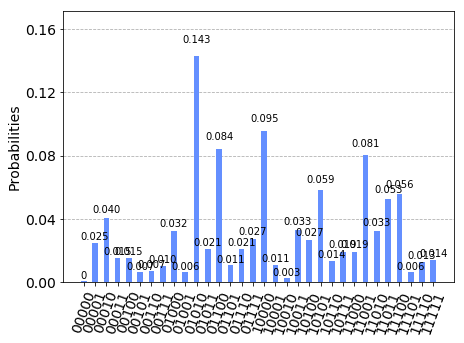

In [17]:
before_optimizing = circuit_results(circ)[0]
plot_histogram(before_optimizing)

In [39]:
def ising_to_qubo(s):
    return 0.5 + 0.5 * s
print(qubo_to_ising(-1),
      qubo_to_ising(1))

0.0 1.0


In [ ]:
A(1 - sum(0.5 + 0.5 * y))^2 + A(sum(n*(0.5+0.5*y)) - sum(w * (0.5+0.5*x)))^2 - B*sum(c*(0.5+0.5*x))
A(n - sum(y))^2 + A(sum(n*(0.5+0.5*y)) - sum(w * (0.5+0.5*x)))^2 - B*sum(c*(0.5+0.5*x))

In [18]:
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)
# Z2 = (I - Z) / 2

C = np.zeros((2**n, 2**n))
for i in range(n):
    for j in range(n):
        res = J[i, j]
        for k in range(n):
            if i == k or j == k:
                res = np.kron(res, Z)
            else:
                res = np.kron(res, I)
        C += res

In [19]:
C

array([[ -40.,    0.,    0., ...,    0.,    0.,    0.],
       [   0., -160.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,  -40., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,  -40.,    0.,    0.],
       [   0.,    0.,    0., ...,    0., -160.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,  -40.]])

In [20]:
def objective_function(params):
    # constructing the circuit, in this example, make sure circ already exists
    circ = qaoa_circuit(params)
    
    # retrieve the results of the quantum circuit
    _, output_distribution = circuit_results(circ)
    
    # calculate the cost function by using the equation above
    cost = np.transpose(output_distribution) @ C @ output_distribution
    return cost

In [21]:
# A COBYLA instance with 500 iterations max and a tolerance level of 0.001
optimizer = COBYLA(maxiter=500, tol=0.001)

# Performing the optimization
ret = optimizer.optimize(num_vars=len(params), objective_function=objective_function, initial_point=params)

# Printing the results
print(ret)

# Using the new parameters and constructing the new parameterized circuit
new_params = ret[0]
circ_after = qaoa_circuit(new_params)

# Getting the results of the optimized circuit
after_optimizing = circuit_results(circ_after)[0]

(array([3.4802259 , 1.63149564, 0.84822659, 3.01911337, 1.36445833,
       1.39310949, 1.77352875, 0.58123774, 2.14176284, 0.82892184,
       1.85362548, 1.97798312, 0.74039384, 1.21832477, 1.58815706,
       1.59961383, 2.63553846, 2.37891172, 2.84133493, 1.22103103]), -23.093530222222224, 155)


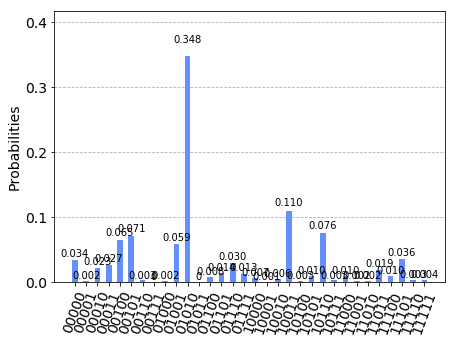

In [22]:
plot_histogram(after_optimizing)

In [23]:
print(after_optimizing)

{'00000': 1019, '00001': 63, '00010': 678, '00011': 817, '00100': 1954, '00101': 2143, '00110': 85, '00111': 12, '01000': 54, '01001': 1756, '01010': 10442, '01011': 1, '01100': 232, '01101': 407, '01110': 898, '01111': 404, '10000': 217, '10001': 32, '10010': 167, '10011': 3287, '10100': 83, '10101': 301, '10110': 2282, '10111': 84, '11000': 288, '11001': 66, '11010': 60, '11011': 581, '11100': 295, '11101': 1086, '11110': 90, '11111': 116}
